<h1 style="font-size:30px;color:#1371B0"><strong>About </strong><strong style="color:black">this notebook:</strong></h1>

This notebook continues the trend of training using `nn.MarginRanking` for toxicity prediction  
This notebook experiments with the following:  
 - MLM pretraining on training/test data
 - Synonym replacement data augmentation with `nlpaug`
 - Adding mean-max instead of pooler head
 - Adding a simpler Trainer API with earlystopping
  
Thanks to debarshichanda's amazing Jigsaw starter for helping define the problem/utilities:  
https://www.kaggle.com/debarshichanda/pytorch-w-b-jigsaw-starter

 ---

In [ ]:
!pip install nlpaug

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
from nlpaug.util import Action

from transformers import (AutoModel, 
                          AutoModelForMaskedLM,
                          AutoTokenizer,
                          AutoConfig,
                          AdamW,
                          LineByLineTextDataset,
                          DataCollatorForLanguageModeling,
                          Trainer,
                          TrainingArguments)

from transformers.optimization import get_cosine_schedule_with_warmup

from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from tqdm import tqdm
import os, random, gc, warnings

gc.enable()
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")
test_df = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

---

# Masked Language Modelling
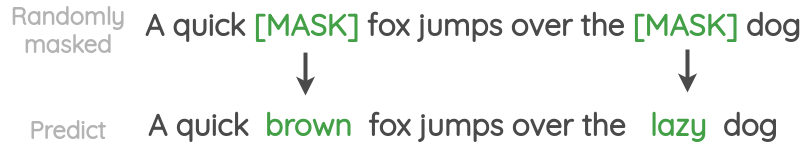

Here we pretrain our transformer which should help align the model more to competition's data-dist prior to fine-tuning.  

This code was based on maunish's excellent CommonLit MLM notebook:  
https://www.kaggle.com/maunish/clrp-pytorch-roberta-pretrain

In [ ]:
pretrain_text = pd.concat([df.less_toxic, df.more_toxic, test_df.text])
pretrain_text.drop_duplicates(inplace = True)
pretrain_text.reset_index(drop = True, inplace = True)
pretrain_text = pretrain_text.apply(lambda x: x.replace('\n',''))

In [ ]:
text  = '\n'.join(pretrain_text.tolist())

with open('text.txt','w', encoding='utf-8') as f:
    f.write(text)

In [ ]:
class pretrain_cfg:
    model_name = 'roberta-base'
    epochs = 1 # adjust
    learning_rate = 5e-05
    train_batch_size = 32
    eval_batch_size = 32
    eval_steps = 100
    block_size = 256
    gradient_accum_steps = 2
    mlm_prob = 0.15
    fp16 = True
    output_dir = 'roberta_pt'

In [ ]:
model = AutoModelForMaskedLM.from_pretrained(pretrain_cfg.model_name)
tokenizer = AutoTokenizer.from_pretrained(pretrain_cfg.model_name)
tokenizer.save_pretrained(pretrain_cfg.output_dir);

In [ ]:
# Sequences are truncated to block size
train_dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="text.txt",
    block_size=pretrain_cfg.block_size)

valid_dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="text.txt",
    block_size=pretrain_cfg.block_size)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, 
    mlm=True, 
    mlm_probability=pretrain_cfg.mlm_prob)

In [ ]:
training_args = TrainingArguments(
    output_dir=pretrain_cfg.output_dir+'_chk',
    overwrite_output_dir=True,
    num_train_epochs=pretrain_cfg.epochs,
    per_device_train_batch_size=pretrain_cfg.train_batch_size,
    per_device_eval_batch_size=pretrain_cfg.eval_batch_size,
    learning_rate=pretrain_cfg.learning_rate,
    gradient_accumulation_steps=pretrain_cfg.gradient_accum_steps,
    fp16=pretrain_cfg.fp16,
    eval_steps=pretrain_cfg.eval_steps,
    evaluation_strategy='steps',
    save_total_limit=2,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
    prediction_loss_only=True,
    report_to='none')

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset)

In [ ]:
trainer.train()
trainer.save_model(pretrain_cfg.output_dir)

 - - -

# Language Data Augmentation

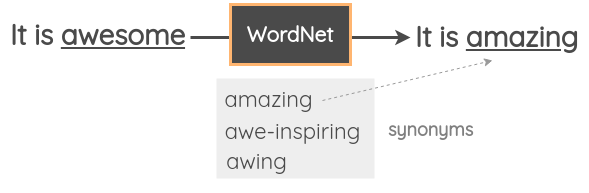

`nlpaug` helps with generating synthetic language data (hopefully in ways which are context/label preserving)  

The library also makes it simple to use context-aware augmentations such as MLM for sentence augmentation  
We'll go with trying simple augmentation using synonym replacement in this case   

A list of supported augmentation strategies can be found in the documentation:  
https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb  

In [ ]:
# adjust aug_max as needed, the run time can be very long..
aug = naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=2) 

In [ ]:
df_aug = df.copy()
new_less_toxic = df.less_toxic.apply(lambda txt: aug.augment(txt))
new_more_toxic = df.more_toxic.apply(lambda txt: aug.augment(txt))

df_aug.less_toxic = new_less_toxic
df_aug.more_toxic = new_more_toxic

In [ ]:
df_aug = pd.concat([df, df_aug])
df_aug.reset_index(drop=True, inplace=True)

---

## Training Config

In [ ]:
class cfg:
    seed = 123 
    train_bs = 20
    valid_bs = 24
    epochs = 5
    lr = 5e-5
    wd = 1e-6
    fp16 = True
    grad_accum_steps = 1
    folds = 5
    margin = 0.5
    max_len = 128
    model_name = pretrain_cfg.output_dir
    output_hidden_states = False
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    checkpoint = lambda fold: f'model_{fold}.pt'

cfg.tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)

## Folds

In [ ]:
skf = StratifiedKFold(n_splits=cfg.folds, shuffle=True, random_state=cfg.seed)

for fold, ( _, val_) in enumerate(skf.split(X=df_aug, y=df_aug.worker)):
    df_aug.loc[val_ , "kfold"] = int(fold)
    
df_aug["kfold"] = df_aug["kfold"].astype(int)

## Reproducibility

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(cfg.seed)

## Dataset

In [ ]:
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.more_toxic = df['more_toxic'].values
        self.less_toxic = df['less_toxic'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        more_toxic = self.more_toxic[index]
        less_toxic = self.less_toxic[index]
        inputs_more_toxic = self.tokenizer.encode_plus(
                                more_toxic,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        inputs_less_toxic = self.tokenizer.encode_plus(
                                less_toxic,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        target = 1
        
        more_toxic_ids = inputs_more_toxic['input_ids']
        more_toxic_mask = inputs_more_toxic['attention_mask']
        
        less_toxic_ids = inputs_less_toxic['input_ids']
        less_toxic_mask = inputs_less_toxic['attention_mask']
        
        
        return {
            'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
            'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
            'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
            'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.long)
        }

## Model Architecture

In [ ]:
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model = AutoModel.from_pretrained(
                     model_name,
                     output_hidden_states=cfg.output_hidden_states)
        
        self.dropout = nn.Dropout(p=0.2)
        
        self.fc = nn.Linear(768, 1)
        self._init_weights(self.fc)
        
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
            
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask).pooler_output
        
#         last_hidden = self.model(input_ids=ids,attention_mask=mask).last_hidden_state
#         mean_pool = torch.mean(last_hidden, 1)
#         _, max_pool = torch.max(last_hidden, 1)
#         mean_max_embeddings = torch.cat((mean_pool, max_pool), 1)

        out = self.dropout(out)
        outputs = self.fc(out)
        return outputs

## Loss Function


In [ ]:
def criterion(outputs1, outputs2, targets):
    return nn.MarginRankingLoss(margin=cfg.margin)(outputs1, outputs2, targets)

## Training Utils

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.001, verbose = None):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.verbose = verbose
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):

        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score: #  + self.delta
            self.counter += 1
            if self.verbose:
                print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            if self.verbose:
                print('Validation score improved ({:.4f} --> {:.4f}). Saving model!'.format(self.val_score, epoch_score))
                
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [ ]:
def make_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = JigsawDataset(df_train, tokenizer=cfg.tokenizer, max_length=cfg.max_len)
    valid_dataset = JigsawDataset(df_valid, tokenizer=cfg.tokenizer, max_length=cfg.max_len)

    train_loader = DataLoader(train_dataset, 
                              batch_size=cfg.train_bs, 
                              num_workers=2, 
                              shuffle=True, 
                              pin_memory=True,
                             )
    
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=cfg.valid_bs, 
                              num_workers=2, 
                              shuffle=False, 
                              pin_memory=True
                             )
    
    return train_loader, valid_loader

## Trainer

In [ ]:
class Trainer:
    def __init__(self, model, device, loss_fn, opt, scheduler = None, grad_accum_steps = 1, fp16 = False):
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.opt = opt
        self.scheduler = scheduler
        self.fp16 = fp16
        self.scaler = GradScaler() if fp16 else None
        self.grad_accum_steps = grad_accum_steps
        
    def train_one_epoch(self, dl):
        self.model.train()
        self.model.zero_grad()
        
        losses = AverageMeter()
        prog_bar = tqdm(enumerate(dl), total = len(dl), leave = False)
        for bi, d in prog_bar:
            more_toxic_ids = d['more_toxic_ids'].to(self.device, dtype = torch.long)
            more_toxic_mask = d['more_toxic_mask'].to(self.device, dtype = torch.long)
            less_toxic_ids = d['less_toxic_ids'].to(self.device, dtype = torch.long)
            less_toxic_mask = d['less_toxic_mask'].to(self.device, dtype = torch.long)
            targets = d['target'].to(self.device, dtype=torch.long)
            
            with autocast(enabled=self.fp16):
                more_toxic_outputs = self.model(more_toxic_ids, more_toxic_mask)
                less_toxic_outputs = self.model(less_toxic_ids, less_toxic_mask)
                loss = self.loss_fn(more_toxic_outputs, less_toxic_outputs, targets)
                prog_bar.set_description('loss: {:.2f}'.format(loss.item()))
                
            loss = loss / self.grad_accum_steps
            losses.update(loss.item(), more_toxic_ids.size(0))
            
            if self.fp16: self.scaler.scale(loss).backward()
            else: loss.backward()
                
            if bi % self.grad_accum_steps == 0 or bi == len(dl) - 1:
                if self.fp16:
                    self.scaler.step(self.opt)
                    self.scaler.update()
                else:
                    self.opt.step()
            
            if self.scheduler: self.scheduler.step()
            self.opt.zero_grad()      
            
    @torch.no_grad()
    def eval_one_epoch(self, dl, **kwargs):
        self.model.eval()
        losses = AverageMeter()
        prog_bar = tqdm(enumerate(dl), total = len(dl), leave = False)
        for bi, d in prog_bar:  
            more_toxic_ids = d['more_toxic_ids'].to(self.device, dtype = torch.long)
            more_toxic_mask = d['more_toxic_mask'].to(self.device, dtype = torch.long)
            less_toxic_ids = d['less_toxic_ids'].to(self.device, dtype = torch.long)
            less_toxic_mask = d['less_toxic_mask'].to(self.device, dtype = torch.long)
            targets = d['target'].to(self.device, dtype=torch.long)
            
            with autocast(enabled=self.fp16):
                more_toxic_outputs = self.model(more_toxic_ids, more_toxic_mask)
                less_toxic_outputs = self.model(less_toxic_ids, less_toxic_mask)
                loss = self.loss_fn(more_toxic_outputs, less_toxic_outputs, targets)
                    
            losses.update(loss.item(), more_toxic_ids.size(0))
        print(f"F{kwargs['fold']} E{str(kwargs['epoch']):2s}"\
              f" Valid Loss: {losses.avg:.4f}")   
        return losses.avg          

---

## Training

In [ ]:
def train_fold(fold, epochs = 5):
    train_dl, valid_dl = make_loaders(df_aug, fold)
    es = EarlyStopping(patience = 5, mode="min", verbose = False)
    
    num_update_steps_per_epoch = len(train_dl)
    max_train_steps = epochs * num_update_steps_per_epoch
    warmup_proportion = 0
    if warmup_proportion != 0:
        warmup_steps = math.ceil((max_train_steps * 2) / 100)
    else:
        warmup_steps = 0
    
    model = JigsawModel(cfg.model_name).to(cfg.device)
    
    opt = AdamW(model.parameters(),
                lr = cfg.lr,
                weight_decay= cfg.wd
               )
    
    scheduler = get_cosine_schedule_with_warmup(
                opt,
                num_warmup_steps=warmup_steps,
                num_training_steps=max_train_steps
                )
    
    
    trainer = Trainer(model, 
                      cfg.device,
                      opt=opt,
                      loss_fn = criterion,
                      scheduler=scheduler,
                      grad_accum_steps=cfg.grad_accum_steps,
                      fp16=cfg.fp16
                     )
    
    for epoch in range(epochs):
        trainer.train_one_epoch(train_dl)
        valid_loss = trainer.eval_one_epoch(valid_dl, fold = fold, epoch = epoch)
        
        es(valid_loss, trainer.model, model_path = cfg.checkpoint(fold))
        
        if es.early_stop:
            break

In [ ]:
for fold in range(cfg.folds):
    train_fold(fold, cfg.epochs)